In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import numpy as np
import scipy.io
from pyDOE import lhs
import tensorflow as tf
import sympy
from sympy.parsing.sympy_parser import parse_expr
import keras

In [3]:
@tf.function
@tf.autograph.experimental.do_not_convert
def dirichlet(model, X, u):
    u_pred = model(X, training=True)
    return u - u_pred

@tf.function
@tf.autograph.experimental.do_not_convert
def neumann(model, X, f): #Currently only for 1D
    u = model(X, training=True)
    u_X = tf.gradients(u, X)[0]
    
    return u_X[:, 1:2] - f

@tf.function
@tf.autograph.experimental.do_not_convert
def periodic(model, X, f): # Currently for only 1D
    t = X[:, 0:1]
    x = X[:, 1:2]
    n = int(X.shape[0]/2)
    u =  model(tf.concat([t, x], 1), training=True)
    u_x = tf.gradients(u, x)[0]
    
    return (u[:n] - u[n:]) + (u_x[:n] - u_x[:n])

In [4]:
def domain_sampler(N, lb, ub):
    lb = np.asarray(lb)
    ub = np.asarray(ub)
    X_f = lb + (ub-lb)*lhs(2, N)
    return X_f

def boundary_sampler(N, lb, ub):
    lb = np.asarray(lb)
    ub = np.asarray(ub)
    N_2 = int(N/2)
    X_b = lb + (ub-lb)*lhs(2, N)
    X_b[0:N_2, 1] = lb[1]
    X_b[N_2:2*N_2, 1] = ub[1]
    return X_b

def initial_sampler(N, lb, ub):
    lb = np.asarray(lb)
    ub = np.asarray(ub)
    X_i = lb + (ub-lb)*lhs(2, N)
    X_i[:, 0] = np.zeros(N)
    return X_i

In [5]:
def initialize_NN(layers):
    inputs =  keras.Input(shape=(layers[0],))
    x = inputs
    for ii in range(1, len(layers) - 1):
        x = keras.layers.Dense(units = layers[ii], activation=tf.tanh,
                                kernel_initializer = tf.keras.initializers.GlorotUniform())(x)
    outputs = keras.layers.Dense(units = layers[-1],
        activation = None,
        kernel_initializer = tf.keras.initializers.GlorotUniform()
    )(x)
    model = keras.Model(inputs, outputs)
    return model

In [6]:
@tf.function
@tf.autograph.experimental.do_not_convert
def pde(model, X):
        
    t = X[:, 0:1]
    x = X[:, 1:2]
    U = model(tf.concat([t,x], 1), training=True)
    u = U[:, 0:1]
    v = U[:, 1:2]
    
    u_x = tf.gradients(u, x)[0]
    u_t = tf.gradients(u, t)[0]
    
    v_x = tf.gradients(v, x)[0]
    v_t = tf.gradients(v, t)[0]
    
    return (u_t + u_x - v, v_t - v_x)

In [7]:
@tf.function
@tf.autograph.experimental.do_not_convert
def ic_func(model, X, u_i, v_i):
    f_pred = model(X, training=True)
    u = f_pred[:, 0:1]
    v = f_pred[:, 1:2]
    ic_loss_u = u - u_i
    ic_loss_v = v - v_i
    return ic_loss_u, ic_loss_v
    
@tf.function
@tf.autograph.experimental.do_not_convert
def bc_func(model, X, u_i, v_i):
    f_pred = model(X, training=True)
    u = f_pred[:, 0:1]
    v = f_pred[:, 1:2]
    bc_loss_u = u - u_i
    bc_loss_v = v - v_i
    return bc_loss_u, bc_loss_v

@tf.function
@tf.autograph.experimental.do_not_convert
def pde_func(model, X):
    pde_loss_u, pde_loss_v = pde(model, X)
    return pde_loss_u, pde_loss_v
    
def callback_GD(it, init_time, loss_value):
    elapsed = time.time() - init_time
    if (it % 1000 == 0):
        print('GD.  It: %d, Loss: %.3e, Time: %.2f' % 
              (it, loss_value, elapsed))
        
def loss_func(model, X_i, u_i, v_i, X_b, u_b, v_b, X_f):
        
    initial_loss_u, initial_loss_v = ic_func(model, X_i, u_i, v_i)
    boundary_loss_u, boundary_loss_v = bc_func(model, X_b, u_b, v_b)
    domain_loss_u, domain_loss_v = pde_func(model, X_f)
                
    return tf.reduce_mean(tf.square(initial_loss_u)) + \
           tf.reduce_mean(tf.square(boundary_loss_u)) + \
           tf.reduce_mean(tf.square(domain_loss_u)) + \
           tf.reduce_mean(tf.square(initial_loss_v)) + \
           tf.reduce_mean(tf.square(boundary_loss_v)) + \
           tf.reduce_mean(tf.square(domain_loss_v))
        
@tf.function
@tf.autograph.experimental.do_not_convert
def loss_and_gradients(model, X_i, u_i, v_i, X_b, u_b, v_b, X_f):

    ## Two separate Gradient Tapes are not necessary... seems "persistent" might
    ## do the job
    with tf.GradientTape() as tape:
        model_loss=loss_func(model, X_i, u_i, v_i, X_b, u_b, v_b, X_f)
    model_gradients = tape.gradient(model_loss, model.trainable_weights)

    return model_loss, model_gradients
        
def train(model, train_config, train_data):
    start_time = time.time()
    
    if (train_config['Optimizer'] == 'adam'):
        optimizer = tf.keras.optimizers.Adam(train_config['learning_rate']) #Passing learning rate to optimizer
    else:
        print("Unknown optimizer")
        exit()
    nIter = train_config['Iterations']
        
        
    X_i = train_data['X_i']
    u_i = train_data['u_i']
    v_i = train_data['v_i']
    X_b = train_data['X_b']
    u_b = train_data['u_b']
    v_b = train_data['v_b']
    X_f = train_data['X_f']

    init_time = time.time()
            
    #losses = np.zeros(nIter)
    for it in range(nIter):
                
        model_loss, model_gradients = loss_and_gradients(model, X_i, u_i, v_i, X_b, u_b, v_b, X_f)
        optimizer.apply_gradients(zip(model_gradients, model.trainable_weights))
                
        if it%10 == 0:
            callback_GD(it, init_time, model_loss)
            #losses[it] = model_loss
                    
    end_time = time.time() - start_time 
    #return losses

In [8]:
#Layers in the neural network. First value is number of input neurons, last is output
layers = [2, 64, 64, 64, 64, 2]

In [9]:
model = initialize_NN(layers)

2022-12-14 14:37:21.635742: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
N_f = 5000 # Domain points
N_i = 400 # Randomly sampled points from IC vector
N_b = 100 # Randomly sampled BC points

In [11]:
dt = 0.1
t_initial = 0.0
t_final = 10.0

t = np.arange(t_initial,t_final+dt,dt)[:,None] #Column vector

In [12]:
dx = 0.0625
x_lb = -16.0
x_ub = 16.0

x = np.arange(x_lb,x_ub,dx)[:,None] #Column vector

In [13]:
X, T = np.meshgrid(x,t)

In [14]:
#X_star is a 2-column array, with the first column being time, second being x
#First set of values are: t=0, all values of x
#Then: t=0.1, all values of x, etc.
X_star = np.hstack((T.flatten()[:,None], X.flatten()[:,None]))

In [15]:
X_star.shape

(51712, 2)

In [16]:
lb = X_star.min(0) 
ub = X_star.max(0)

In [17]:
#X_i is the initial data, t=0, all values of x
X_i = np.hstack((T[0:1,:].T, X[0:1,:].T))

In [18]:
dt = 0.0001
X_i_dt = np.copy(X_i)
X_i_dt[:,0] += dt

In [19]:
def define_initial_condition(x,mu,sigma):
    return (1.0/(sigma*np.sqrt(2.0*np.pi)))*np.exp(-0.5*((x - mu)/sigma)**2)

In [20]:
u_i = 0.5*define_initial_condition(x,5.0,0.5)
v_i = 0.5*define_initial_condition(x,-5.0,0.5)
#u_i = zeros(len(v_i))[:, None]

In [21]:
u_i.shape

(512, 1)

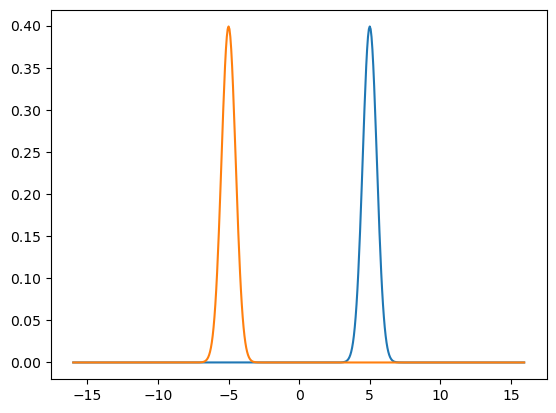

In [22]:
plot(x,u_i)
plot(x,v_i)

In [23]:
u_i.shape

(512, 1)

In [24]:
#X_lb is lower bound of domain, i.e. minimum value of x for all times
#X_ub is upper bound of domain, i.e. maximum value of x for all times
X_lb = np.hstack((T[:,0:1], X[:,0:1])) 
X_ub = np.hstack((T[:,-1:], X[:,-1:])) 

In [25]:
#Values of u field at lower and upper bounds (just set to zero)
u_lb = np.zeros((len(X[:,0:1]),1))
u_ub = np.zeros((len(X[:,-1:]),1))

In [26]:
X_b = np.vstack((X_lb, X_ub))
u_b = np.vstack((u_lb, u_ub))
v_b = u_b.copy()

In [27]:
X_f = domain_sampler(N_f, lb, ub)

In [28]:
idx = np.random.choice(X_i.shape[0], N_i, replace=False)
X_i = X_i[idx, :]
u_i = u_i[idx, :]
v_i = v_i[idx, :]

In [29]:
idx = np.random.choice(X_b.shape[0], N_b, replace=False)
X_b = X_b[idx, :] 
u_b = u_b[idx, :]
v_b = v_b[idx, :]

In [30]:
training_data = {'X_i': X_i.astype('float32'), 'u_i': u_i.astype('float32'), 'v_i': v_i.astype('float32'),
                 'X_b': X_b.astype('float32'), 'u_b': u_b.astype('float32'), 'v_b': v_b.astype('float32'),
                 'X_f': X_f.astype('float32')}

In [31]:
train_config = {'Optimizer': 'adam',
                 'learning_rate': 0.001, 
                 'Iterations' : 10000}

In [32]:
time_GD = train(model, train_config, training_data)

GD.  It: 0, Loss: 6.152e-01, Time: 1.28
GD.  It: 1000, Loss: 5.174e-03, Time: 38.72
GD.  It: 2000, Loss: 4.502e-03, Time: 75.57
GD.  It: 3000, Loss: 3.630e-03, Time: 112.97
GD.  It: 4000, Loss: 2.893e-03, Time: 149.32
GD.  It: 5000, Loss: 5.282e-04, Time: 185.41
GD.  It: 6000, Loss: 1.706e-04, Time: 221.30
GD.  It: 7000, Loss: 1.015e-04, Time: 257.67
GD.  It: 8000, Loss: 7.549e-05, Time: 295.04
GD.  It: 9000, Loss: 5.954e-05, Time: 331.84


In [33]:
u_pred = model(X_star).numpy()[:,0]

In [34]:
v_pred = model(X_star).numpy()[:,1]

In [35]:
u_pred = np.reshape(u_pred, (t.shape[0], x.shape[0]))
v_pred = np.reshape(v_pred, (t.shape[0], x.shape[0]))

In [36]:
filenames = []
for ii in range(len(t)):
    #plt.plot(Exact[ii], c= actual_col, label = "Actual")
    axis([-32.0,32.0,0.0,1.0])
    plt.plot(x,u_pred[ii])
    filenames.append("advection_"+str(ii).zfill(5)+".png")
    plt.savefig(filenames[-1])
    plt.clf()

<Figure size 640x480 with 0 Axes>

In [37]:
import imageio
with imageio.get_writer('movie.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.v2.imread(filename)
        writer.append_data(image)

In [38]:
for filename in set(filenames):
    os.remove(filename)

In [39]:
os.remove('movie.gif')